<a href="https://colab.research.google.com/github/Edenshmuel/PapaJohns_Data_Science_Project/blob/Nadav/Model_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from holidays import country_holidays
import matplotlib.pyplot as plt

In [4]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')

<ipython-input-4-20e4947fae02>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')


In [5]:
desc_encoding_map = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/desc_encoding_map.csv')

In [6]:
# עותק מהנתונים המקוריים
df = cleaned_data.copy()

In [7]:
# הסרת עמודות טקסטואליות/מיותרות
columns_to_drop = ['christian_holiday_name', 'jewish_holiday_name', 'Date', 'order', 'סכום']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [8]:
# recent_avg_quantity
df['recent_avg_quantity'] = (df.groupby('clean_desc_encoded')['כמות']
    .rolling(window=30, min_periods=1).mean()
    .reset_index(0, drop=True))

In [9]:
# הגדרת מטרת החיזוי והפיצ'רים
target = 'כמות'
X = df.drop(columns=[target])
y = df[target]

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [11]:
object_columns = X_train.select_dtypes(include='object').columns

In [12]:
encoders = {}
for col in object_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    encoders[col] = le  # לשמירה אם נצטרך תחזית בעתיד

In [13]:
# בניית המודל
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

# אימון המודל
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
model_features = X_train.columns.tolist()

In [15]:
def extended_evaluate_model(model, X, y, label='Set'):
    y_pred = model.predict(X)

    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / np.where(y == 0, 1, y))) * 100
    r2 = r2_score(y, y_pred)

    n = X.shape[0]  # num of samples
    k = X.shape[1]  # num of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    print(f'📊 Evaluation on {label}')
    print(f'MAE:  {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'R²:   {r2:.4f}')
    print(f'Adjusted R²: {adj_r2:.4f}')

    return mae, rmse, mape, r2, adj_r2

In [16]:
extended_evaluate_model(model, X_train, y_train, 'Train')
extended_evaluate_model(model, X_val, y_val, 'Validation')
extended_evaluate_model(model, X_test, y_test, 'Test')

📊 Evaluation on Train
MAE:  0.29
RMSE: 0.57
MAPE: 20.56%
R²:   0.2131
Adjusted R²: 0.2130
📊 Evaluation on Validation
MAE:  0.30
RMSE: 0.60
MAPE: 20.88%
R²:   0.0961
Adjusted R²: 0.0954
📊 Evaluation on Test
MAE:  0.29
RMSE: 0.67
MAPE: 20.62%
R²:   0.1078
Adjusted R²: 0.1073


(0.2939707934856415,
 np.float64(0.6676862688232658),
 np.float64(20.615556774155916),
 0.10782885551452637,
 0.1073459848554773)

In [17]:
quantity_min = df['כמות'].min()
quantity_max = df['כמות'].max()
quantity_mean = df['כמות'].mean()
quantity_std = df['כמות'].std()

quantity_min, quantity_max, quantity_mean, quantity_std

(0, 80, np.float64(1.2283138812797245), 0.6513769783150126)

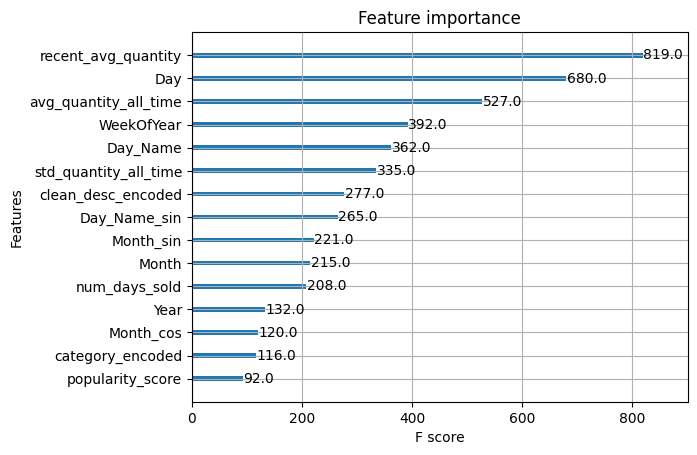

In [18]:
xgb.plot_importance(model, max_num_features=15)
plt.show()

In [19]:
def build_future_features(forecast_date: str, full_df, desc_map_df, model_features):
    date = pd.to_datetime(forecast_date)
    day = date.day
    month = date.month
    year = date.year
    week = date.isocalendar().week
    day_name = ((date.dayofweek + 1) % 7) + 1
    is_weekend = int(day_name in [6, 7])

    il_holidays = country_holidays('IL')
    christian_holidays = country_holidays('US')
    is_jewish_holiday = date in il_holidays
    is_christian_holiday = date in christian_holidays
    is_near_jewish_holiday = ((date + pd.Timedelta(days=1) in il_holidays) or
                              (date - pd.Timedelta(days=1) in il_holidays))
    is_day_before_new_year = int(month == 12 and day == 31)
    is_start_of_month = int(day <= 3)
    is_end_of_month = int(day >= 28)
    season = (month % 12) // 3 + 1

    day_name_sin = np.sin(2 * np.pi * day_name / 7)
    day_name_cos = np.cos(2 * np.pi * day_name / 7)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    categories = full_df['clean_desc_encoded'].unique()
    avg_quantity = full_df.groupby('clean_desc_encoded')['כמות'].mean()
    std_quantity = full_df.groupby('clean_desc_encoded')['כמות'].std()
    days_sold = full_df.groupby('clean_desc_encoded')['Date'].nunique()
    max_days = days_sold.max()

    portion_map = desc_map_df.set_index('code')['portion_type'].to_dict() if 'portion_type' in desc_map_df.columns else {}

    rows = []
    for cat in categories:
        recent_avg = full_df[
            (full_df['clean_desc_encoded'] == cat) &
            (pd.to_datetime(full_df['Date']) < date)
        ].sort_values('Date').tail(30)['כמות'].mean()

        row = {
            'clean_desc_encoded': cat,
            'Year': year, 'Month': month, 'Day': day, 'WeekOfYear': week,
            'Day_Name': day_name, 'Is_Weekend': is_weekend,
            'is_jewish_holiday': is_jewish_holiday,
            'is_christian_holiday': is_christian_holiday,
            'is_near_jewish_holiday': is_near_jewish_holiday,
            'is_day_before_new_year': is_day_before_new_year,
            'is_start_of_month': is_start_of_month,
            'is_end_of_month': is_end_of_month,
            'Season': season,
            'Day_Name_sin': day_name_sin, 'Day_Name_cos': day_name_cos,
            'Month_sin': month_sin, 'Month_cos': month_cos,
            'recent_avg_quantity': recent_avg if not np.isnan(recent_avg) else 0,
            'avg_quantity_all_time': avg_quantity.get(cat, 0),
            'std_quantity_all_time': std_quantity.get(cat, 0),
            'num_days_sold': days_sold.get(cat, 0),
            'popularity_score': days_sold.get(cat, 0) / max_days if max_days > 0 else 0,
            'portion_type': portion_map.get(cat, 'unknown')
        }

        for col in model_features:
            if col not in row:
                row[col] = 0

        rows.append(row)

    future_df = pd.DataFrame(rows)
    desc_map_dict = desc_map_df.set_index('code')['Unnamed: 0'].to_dict()
    future_df['category_name'] = future_df['clean_desc_encoded'].map(desc_map_dict)

    return future_df

In [20]:
def predict_sales_by_date(forecast_date: str, model, full_df, model_features, desc_map_df):
    future_df = build_future_features(
        forecast_date=forecast_date,
        full_df=full_df,
        desc_map_df=desc_map_df,
        model_features=model_features
    )

    # קידוד portion_type אם נדרש
    if 'portion_type' in future_df.columns and future_df['portion_type'].dtype == 'object':
        le = LabelEncoder()
        future_df['portion_type'] = le.fit_transform(future_df['portion_type'])

    future_df['predicted_quantity'] = np.ceil(model.predict(future_df[model_features])).astype(int)

    return future_df[['category_name', 'predicted_quantity']].sort_values(by='predicted_quantity', ascending=False)

In [21]:
forecast_df = predict_sales_by_date(
    forecast_date='2025-01-03',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

forecast_df.head()

,category_name,predicted_quantity
224,פיצה מיוחדת ממהדורת חורף פיצה קלאסית,7
54,2 פיצות 14,6
55,2 תוספות,6
100,2תוספות,6
226,6 גבינות 14 דקה,6


In [22]:
def predict_sales_by_date_range(start_date, end_date, model, full_df, model_features, desc_map_df):
    dates = pd.date_range(start=start_date, end=end_date)
    all_rows = []

    for single_date in dates:
        daily = predict_sales_by_date(
            forecast_date=single_date.strftime('%Y-%m-%d'),
            model=model,
            full_df=full_df,
            model_features=model_features,
            desc_map_df=desc_map_df
        )
        daily['Date'] = single_date
        all_rows.append(daily)

    return pd.concat(all_rows, ignore_index=True)

In [23]:
xgb_forecast_range = predict_sales_by_date_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [24]:
xgb_forecast_range

,category_name,predicted_quantity,Date
0,פיצה קלאסית איטסיין/ללא גלוטן ב 50%,9,2025-01-01
1,רולס נוגט,8,2025-01-01
2,אצבעות גבינה פסח,8,2025-01-01
3,2 פיצות 14,7,2025-01-01
4,6 גבינות 14 דקה,7,2025-01-01
...,...,...,...
1703,הבלקנית 14,1,2025-01-07
1704,עם רוטב פיסטוק,1,2025-01-07
1705,מונסטר אולטרה,1,2025-01-07
1706,קלאסית 12,1,2025-01-07


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_sales_with_sarima(forecast_date: str, model, full_df, model_features, desc_map_df):
    future_df = build_future_features(
        forecast_date=forecast_date,
        full_df=full_df,
        desc_map_df=desc_map_df,
        model_features=model_features
    )

    if 'portion_type' in future_df.columns and future_df['portion_type'].dtype == 'object':
        le = LabelEncoder()
        future_df['portion_type'] = le.fit_transform(future_df['portion_type'])

    categories = future_df['clean_desc_encoded'].unique()
    future_df_model_input = future_df[model_features]
    xgb_pred = model.predict(future_df_model_input)

    sarima_correction = []
    for cat in categories:
        cat_df = full_df[full_df['clean_desc_encoded'] == cat].copy()
        cat_df['Date'] = pd.to_datetime(cat_df['Date'])
        cat_df = cat_df.sort_values('Date').set_index('Date')

        try:
            X_cat = cat_df[model_features]
            y_cat = cat_df['כמות']
            y_pred = model.predict(X_cat)
            residuals = y_cat - y_pred
        except:
            sarima_correction.append(0)
            continue

        if len(residuals) < 30:
            sarima_correction.append(0)
            continue

        try:
            sarima = SARIMAX(residuals, order=(1,1,1), seasonal_order=(1,1,1,7))
            sarima_fitted = sarima.fit(disp=False)
            forecast = sarima_fitted.forecast(steps=1)[0]
        except:
            forecast = 0

        sarima_correction.append(forecast)

    future_df['predicted_quantity'] = np.ceil(xgb_pred + sarima_correction).astype(int)
    future_df['Date'] = forecast_date

    return future_df[['Date', 'category_name', 'predicted_quantity']].sort_values(by='predicted_quantity', ascending=False)

In [43]:
forecast = predict_sales_with_sarima(
    forecast_date='2025-01-03',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [42]:
forecast.head()

,Date,category_name,predicted_quantity
224,2025-01-03,פיצה מיוחדת ממהדורת חורף פיצה קלאסית,7
54,2025-01-03,2 פיצות 14,6
55,2025-01-03,2 תוספות,6
100,2025-01-03,2תוספות,6
226,2025-01-03,6 גבינות 14 דקה,6


In [27]:
def predict_sales_with_sarima_range(start_date: str, end_date: str, model, full_df, model_features, desc_map_df, verbose=False):
    """
    מחזירה תחזית לכל יום בטווח תאריכים, לפי קטגוריה.
    התחזית מבוססת על מודל XGBoost עם תיקון SARIMA לפי שאריות.
    """
    date_range = pd.date_range(start=start_date, end=end_date)
    all_forecasts = []

    for single_date in date_range:
        if verbose:
            print("📅 Forecasting for:", single_date.strftime('%Y-%m-%d'))

        daily_forecast = predict_sales_with_sarima(
            forecast_date=single_date.strftime('%Y-%m-%d'),
            model=model,
            full_df=full_df,
            model_features=model_features,
            desc_map_df=desc_map_df
        )

        all_forecasts.append(daily_forecast)

    forecast_df = pd.concat(all_forecasts, ignore_index=True)

    return forecast_df[['Date', 'category_name', 'predicted_quantity']]\
        .sort_values(by=['Date', 'predicted_quantity'], ascending=[True, False])

In [28]:
hybrid_forecast_range = predict_sales_with_sarima_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [29]:
hybrid_forecast_range

,Date,category_name,predicted_quantity
0,2025-01-01,פיצה קלאסית איטסיין/ללא גלוטן ב 50%,9
1,2025-01-01,רולס נוגט,8
2,2025-01-01,אצבעות גבינה פסח,8
3,2025-01-01,2 פיצות 14,7
4,2025-01-01,6 גבינות 14 דקה,7
...,...,...,...
1703,2025-01-07,הבלקנית 14,1
1704,2025-01-07,עם רוטב פיסטוק,1
1705,2025-01-07,מונסטר אולטרה,1
1706,2025-01-07,קלאסית 12,1


In [30]:
def summarize_daily_forecast(forecast_df):
    """
    סיכום יומי כולל: כמה פריטים צפויים להימכר בכל יום
    """
    return (
        forecast_df
        .groupby('Date', as_index=False)
        .agg(total_predicted_sales=('predicted_quantity', 'sum'))
        .sort_values('Date'))

In [31]:
# תחזית לפי טווח תאריכים
hybrid_forecast_range = predict_sales_with_sarima_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

# סכימת תחזיות יומיות
daily_summary = summarize_daily_forecast(hybrid_forecast_range)

In [32]:
daily_summary

,Date,total_predicted_sales
0,2025-01-01,542
1,2025-01-02,537
2,2025-01-03,545
3,2025-01-04,546
4,2025-01-05,539
5,2025-01-06,533
6,2025-01-07,512


In [33]:
def plot_daily_forecast(summary_df):
    plt.figure(figsize=(10, 5))
    plt.plot(summary_df['Date'], summary_df['total_predicted_sales'], marker='o')
    plt.title("Daily forecast of total expected sales")
    plt.xlabel("Date")
    plt.ylabel("Total expected items")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

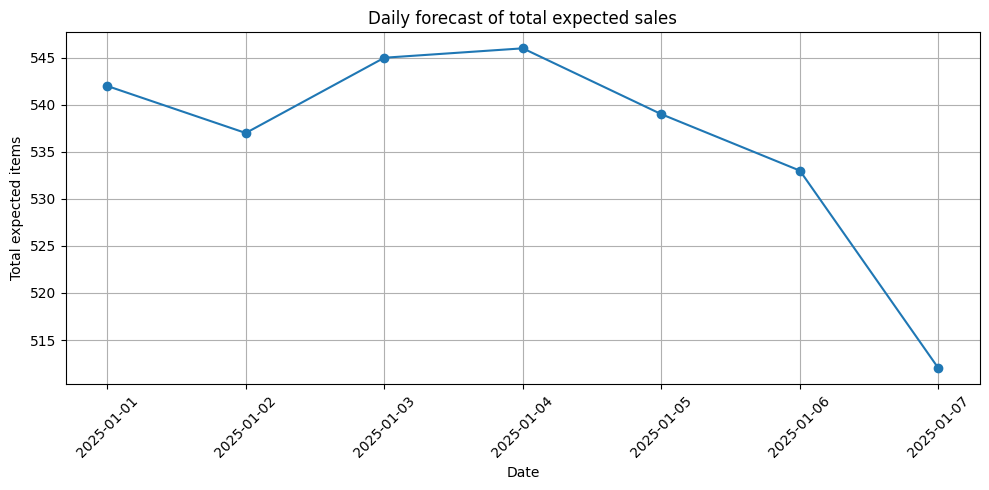

In [34]:
plot_daily_forecast(daily_summary)

In [35]:
xgb_only_forecast = predict_sales_by_date_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

sarima_forecast = predict_sales_with_sarima_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [36]:
xgb_summary = summarize_daily_forecast(xgb_only_forecast)
sarima_summary = summarize_daily_forecast(sarima_forecast)

In [37]:
xgb_summary['Date'] = pd.to_datetime(xgb_summary['Date'])
sarima_summary['Date'] = pd.to_datetime(sarima_summary['Date'])

In [38]:
comparison_df = pd.merge(
    xgb_summary.rename(columns={'total_predicted_sales': 'XGBoost'}),
    sarima_summary.rename(columns={'total_predicted_sales': 'XGBoost + SARIMA'}),
    on='Date')

In [39]:
def plot_forecast_comparison(comparison_df):
    plt.figure(figsize=(10, 5))
    plt.plot(comparison_df['Date'], comparison_df['XGBoost'], marker='o', label='XGBoost')
    plt.plot(comparison_df['Date'], comparison_df['XGBoost + SARIMA'], marker='s', label='XGBoost + SARIMA')
    plt.title("Daily Forecast Comparison: XGBoost vs. XGBoost + SARIMA")
    plt.xlabel("Date")
    plt.ylabel("Total expected items")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

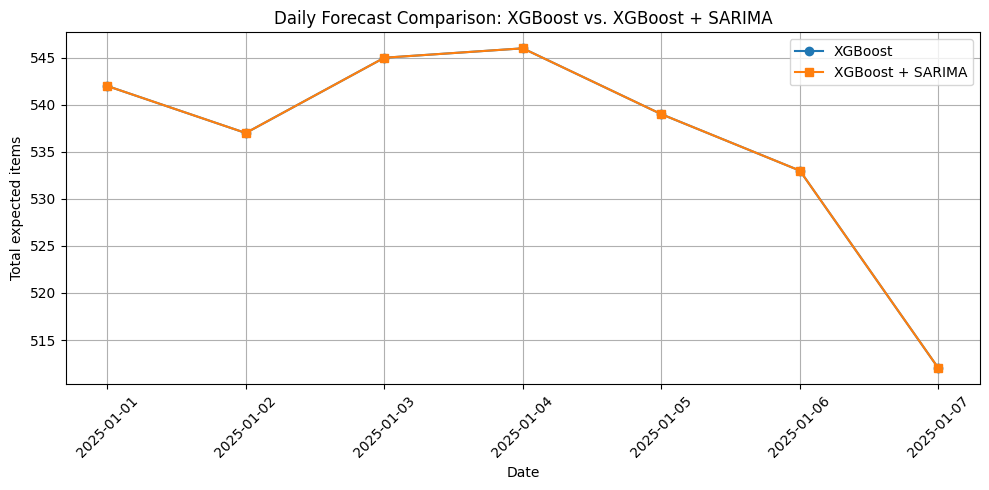

In [40]:
plot_forecast_comparison(comparison_df)

In [41]:
(comparison_df['XGBoost'] == comparison_df['XGBoost + SARIMA']).all()

np.True_